In [1]:
import csv
import pandas as pd
import librosa
import gdown
import zipfile
import os
import umap  # pip install umap-learn
from scipy import signal
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy.special import expit  # sigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, f1_score, accuracy_score, confusion_matrix,
                             roc_auc_score, roc_curve, auc, precision_score,
                             recall_score, average_precision_score, precision_recall_curve)
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # for PCA
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

Auxiliar functions


In [2]:
def metrics_calculation(y_test, y_pred, decision_scores, label="Anomaly"):

    # print(f"True Labels (0=label, 1=Sauim):\n{y_test}")
    # print(f"Predicted Labels (0=label, 1=Sauim):\n{y_pred}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(4.2, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18},  cbar=False,
                xticklabels=[label, 'Sauim'], yticklabels=[label, 'Sauim'])
    # plt.ylabel('Actual Label', fontsize=18)
    # plt.xlabel('Predicted Label', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)  # rotation=0 keeps them horizontal
    # plt.title(label, fontsize=20)
    plt.savefig("ConfusionMatrix_"+label+".pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred) # Accuracy (may be misleading with imbalanced data)
    f1 = f1_score(y_test, y_pred, pos_label=1, average='weighted') # F1-score for the 'sauim' class (positive class)

    # Precision and Recall
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    # ROC AUC Curve (useful if you want to choose a threshold based on decision_function)
    # For ROC AUC, 1 represents the positive class (sauim)
    fpr, tpr, thresholds = roc_curve(y_test, decision_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    print(f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, Rec: {recall:.2f}, F1: {f1:.2f}, roc_auc: {roc_auc:.2f}")
    return fpr, tpr, roc_auc

Automatically download the necessary files

In [18]:
# https://drive.google.com/file/d/1VBmgrluBhVRyqz-n_Cu564klZbqeFBnk/view?usp=sharing

extraction_path = '/content'

file_id = '1VBmgrluBhVRyqz-n_Cu564klZbqeFBnk'
if not os.path.exists(os.path.join(extraction_path, 'embedding_vectors.zip')):
    gdown.download(id=file_id, output='embedding_vectors.zip', quiet=False)

# Open and extract files
with zipfile.ZipFile('embedding_vectors.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print(f'Files extracted')

sauim_embedding_vectors = np.load('embedding_vectors/sauim_embedding_vectors.npy')
anurans_embedding_vectors = np.load('embedding_vectors/anurans_embedding_vectors.npy')
background_embedding_vectors = np.load('embedding_vectors/background_embedding_vectors.npy')
birds_embedding_vectors = np.load('embedding_vectors/birds_embedding_vectors.npy')
anthrophony_embedding_vectors = np.load('embedding_vectors/anthrophony_embedding_vectors.npy')
geophony_embedding_vectors = np.load('embedding_vectors/geophony_embedding_vectors.npy')
soundscape_embedding_vectors = np.load('embedding_vectors/soundscape_embedding_vectors.npy')

sauim_spectrograms = np.load('embedding_vectors/sauim_spectrograms.npy')
anurans_spectrograms = np.load('embedding_vectors/anurans_spectrograms.npy')
background_spectrograms = np.load('embedding_vectors/background_spectrograms.npy')
birds_spectrograms = np.load('embedding_vectors/birds_spectrograms.npy')
anthrophony_spectrograms = np.load('embedding_vectors/anthrophony_spectrograms.npy')
geophony_spectrograms = np.load('embedding_vectors/geophony_spectrograms.npy')
soundscape_spectrograms = np.load('embedding_vectors/soundscape_spectrograms.npy')

Files extracted


In [19]:
sr = 32000
window_len = int(5*sr)
step = 1
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

One-class classification

In [20]:
X_train = np.array(sauim_embedding_vectors)

# For this example, we'll train on the 'normal_data'
X_train_normal, X_test_normal = train_test_split(X_train, test_size=0.3, random_state=42)

# Create labels
X_test_background_combined = np.concatenate([X_test_normal, background_embedding_vectors])

# Create labels, 1 means normal data (sauim)
y_train_normal = np.ones(X_train_normal.shape[0]).astype(int)
y_test_normal = np.ones(X_test_normal.shape[0]).astype(int)

y_test_background_combined = np.concatenate([y_test_normal, np.zeros(background_embedding_vectors.shape[0])]).astype(int)

print(f"Shape of X_train_normal (used for fitting): {X_train_normal.shape}")
print(f"Shape of X_test_normal (part of test set): {X_test_normal.shape}")
print(f"Shape of X_test_combined (combined test set): {X_test_background_combined.shape}")

Shape of X_train_normal (used for fitting): (82, 1280)
Shape of X_test_normal (part of test set): (36, 1280)
Shape of X_test_combined (combined test set): (215, 1280)


One-class classifier train

In [21]:
# --- 3. Instantiate the One-Class SVM Model ---
# Key parameters:
#   nu: An upper bound on the fraction of training errors (outliers) and a lower
#       bound of the fraction of support vectors.
#       A common range is 0.01 to 0.1.
#   kernel: 'rbf'
#   gamma: 'auto' is `1 / n_features`

clf = OneClassSVM(kernel='rbf', nu=0.07, gamma='auto') # We might need to tune this with GridSearchCV/RandomizedSearchCV if performance isn't good.
clf.fit(X_train_normal)

OneClassSVM(gamma='auto', nu=0.07)

## Score on background noise

The .predict() method returns -1 for outliers/anomalies and 1 for inliers/normal points.

The .decision_function() method returns the signed distance to the hyperplane.

Positive values indicate inliers, negative values indicate outliers.

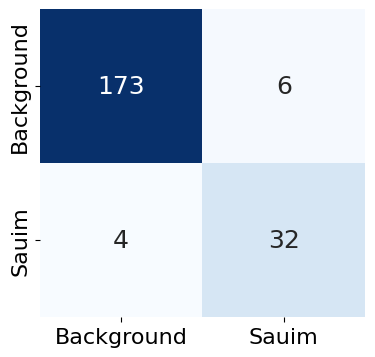

Acc: 0.95, Prec: 0.84, Rec: 0.89, F1: 0.95, roc_auc: 0.98


In [22]:
predictions = clf.predict(X_test_background_combined)
decision_scores = clf.decision_function(X_test_background_combined)

# Convert predictions to 0 for normal, 1 for anomaly to match y_true_combined
# Note: OCSVM predicts 1 for inliers (normal) and -1 for outliers (anomalies)
# So, we map 1 -> 1 and -1 -> 0
y_pred = np.where(predictions == -1, 0, 1)

# --- 6. Evaluate the Model ---
fpr1, tpr1, roc_auc_background = metrics_calculation(y_test_background_combined, y_pred, decision_scores, label="Background")

Permutation Importance (global)
Avalia a queda de desempenho quando embaralha cada feature. Fácil, rápido e robusto.

O que medir? Use AUC-ROC/PR sobre y_test_combined usando -decision_function(X) (maior = mais anômalo).

Prós: Simples, interpreta globalmente.

Contras: Requer rótulos (mesmo que sintéticos) e é global (não explica um ponto específico).

In [23]:
def anomaly_score(X):  # maior = mais anômalo
    return (clf.decision_function(X)).ravel()

base_scores = anomaly_score(X_test_background_combined)
base_auc = roc_auc_score(y_test_background_combined, base_scores)

print(f"Baseline AUC: {base_auc:.2f}")

rng = np.random.RandomState(42)
n_repeats = 10
importances = []

for j in range(X_test_background_combined.shape[1]):
    auc_drops = []
    for _ in range(n_repeats):
        Xp = X_test_background_combined.copy()
        Xp[:, j] = shuffle(Xp[:, j], random_state=rng)
        auc_p = roc_auc_score(y_test_background_combined, anomaly_score(Xp))
        auc_drops.append(base_auc - auc_p)
    importances.append(np.mean(auc_drops))

importances = np.array(importances)
rank = np.argsort(importances)[::-1]
for k in rank[:10]:
    print(f"feat {k}: ΔAUC = {importances[k]:.4f}")


Baseline AUC: 0.98
feat 855: ΔAUC = 0.0021
feat 1040: ΔAUC = 0.0018
feat 830: ΔAUC = 0.0017
feat 1251: ΔAUC = 0.0016
feat 92: ΔAUC = 0.0015
feat 1045: ΔAUC = 0.0015
feat 862: ΔAUC = 0.0015
feat 938: ΔAUC = 0.0014
feat 1055: ΔAUC = 0.0014
feat 321: ΔAUC = 0.0014


## Anuran comparison

Shape of X_test_anuran_combined (combined test set): (158, 1280)


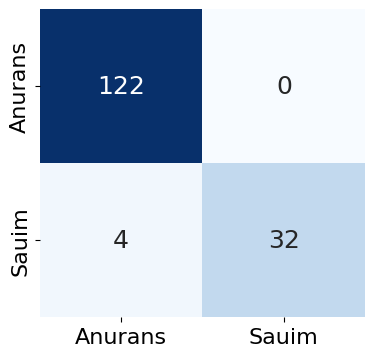

Acc: 0.97, Prec: 1.00, Rec: 0.89, F1: 0.97, roc_auc: 1.00


In [24]:
# X_test_anuran_anomaly = np.array(anurans_embedding_vectors)
X_test_anuran_combined = np.concatenate([X_test_normal, anurans_embedding_vectors])
y_test_anuran_anomaly = np.zeros(anurans_embedding_vectors.shape[0]).astype(int)
y_test_anuran_combined = np.concatenate([y_test_normal, y_test_anuran_anomaly]).astype(int)

print(f"Shape of X_test_anuran_combined (combined test set): {X_test_anuran_combined.shape}")

predictions = clf.predict(X_test_anuran_combined)
decision_scores = clf.decision_function(X_test_anuran_combined)

y_pred = np.where(predictions == -1, 0, 1)

fpr2, tpr2, roc_auc_anuran = metrics_calculation(y_test_anuran_combined, y_pred,
                                               decision_scores,
                                               label="Anurans")

## bird comparison

Shape of X_test_birds_combined (combined test set): (166, 1280)


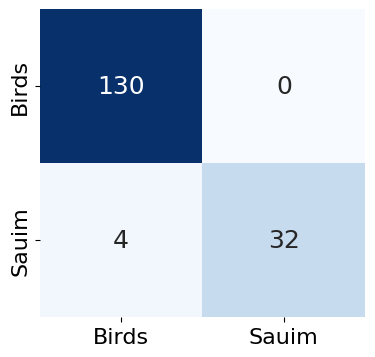

Acc: 0.98, Prec: 1.00, Rec: 0.89, F1: 0.98, roc_auc: 1.00


In [25]:
X_test_birds_combined = np.concatenate([X_test_normal, birds_embedding_vectors])
y_test_birds_anomaly = np.zeros(birds_embedding_vectors.shape[0]).astype(int)
y_test_birds_combined = np.concatenate([y_test_normal, y_test_birds_anomaly]).astype(int)

print(f"Shape of X_test_birds_combined (combined test set): {X_test_birds_combined.shape}")

predictions = clf.predict(X_test_birds_combined)
decision_scores = clf.decision_function(X_test_birds_combined)

y_pred = np.where(predictions == -1, 0, 1)

fpr3, tpr3, roc_auc_birds = metrics_calculation(y_test_birds_combined, y_pred,
                                               decision_scores,
                                               label="Birds")

### Anthrophony

Shape of X_test_anthrophony_combined (combined test set): (120, 1280)


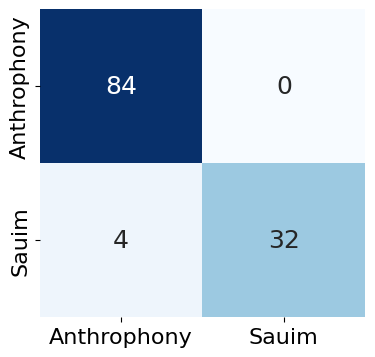

Acc: 0.97, Prec: 1.00, Rec: 0.89, F1: 0.97, roc_auc: 1.00


In [26]:
X_test_anthrophony_combined = np.concatenate([X_test_normal, anthrophony_embedding_vectors])
y_test_anthrophony_anomaly = np.zeros(anthrophony_embedding_vectors.shape[0]).astype(int)
y_test_anthrophony_combined = np.concatenate([y_test_normal, y_test_anthrophony_anomaly]).astype(int)

print(f"Shape of X_test_anthrophony_combined (combined test set): {X_test_anthrophony_combined.shape}")

predictions = clf.predict(X_test_anthrophony_combined)
decision_scores = clf.decision_function(X_test_anthrophony_combined)

y_pred = np.where(predictions == -1, 0, 1)

fpr4, tpr4, roc_auc_anthrophony = metrics_calculation(y_test_anthrophony_combined, y_pred,
                                               decision_scores,
                                               label="Anthrophony")

### Geophony

Shape of X_test_geophony_combined (combined test set): (113, 1280)


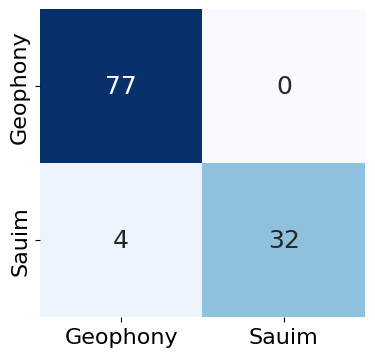

Acc: 0.96, Prec: 1.00, Rec: 0.89, F1: 0.96, roc_auc: 1.00


In [27]:
X_test_geophony_combined = np.concatenate([X_test_normal, geophony_embedding_vectors])
y_test_geophony_anomaly = np.zeros(geophony_embedding_vectors.shape[0]).astype(int)
y_test_geophony_combined = np.concatenate([y_test_normal, y_test_geophony_anomaly]).astype(int)

print(f"Shape of X_test_geophony_combined (combined test set): {X_test_geophony_combined.shape}")

predictions = clf.predict(X_test_geophony_combined)
decision_scores = clf.decision_function(X_test_geophony_combined)

y_pred = np.where(predictions == -1, 0, 1)

fpr5, tpr5, roc_auc_geophony = metrics_calculation(y_test_geophony_combined, y_pred,
                                               decision_scores,
                                               label="Geophony")

## Comparison all datasets

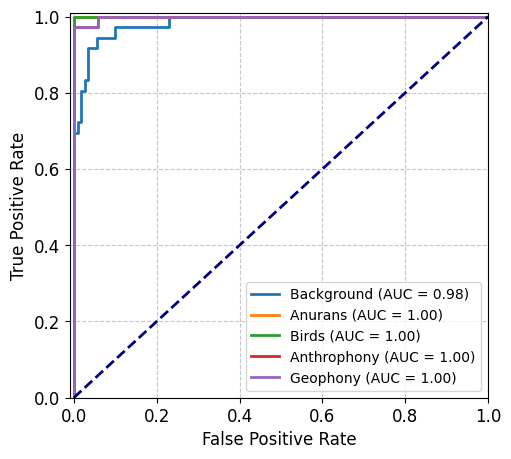

In [29]:
plt.figure(figsize=(5.4, 5))
plt.plot(fpr1, tpr1, lw=2, label='Background (AUC = %0.2f)' % roc_auc_background)
plt.plot(fpr2, tpr2, lw=2, label='Anurans (AUC = %0.2f)' % roc_auc_anuran)
plt.plot(fpr3, tpr3, lw=2, label='Birds (AUC = %0.2f)' % roc_auc_birds)
plt.plot(fpr4, tpr4, lw=2, label='Anthrophony (AUC = %0.2f)' % roc_auc_anthrophony)
plt.plot(fpr4, tpr4, lw=2, label='Geophony (AUC = %0.2f)' % roc_auc_geophony)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.legend(loc="lower right", fontsize=10)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  # rotation=0 keeps them horizontal
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("ROC_curves.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## PCA

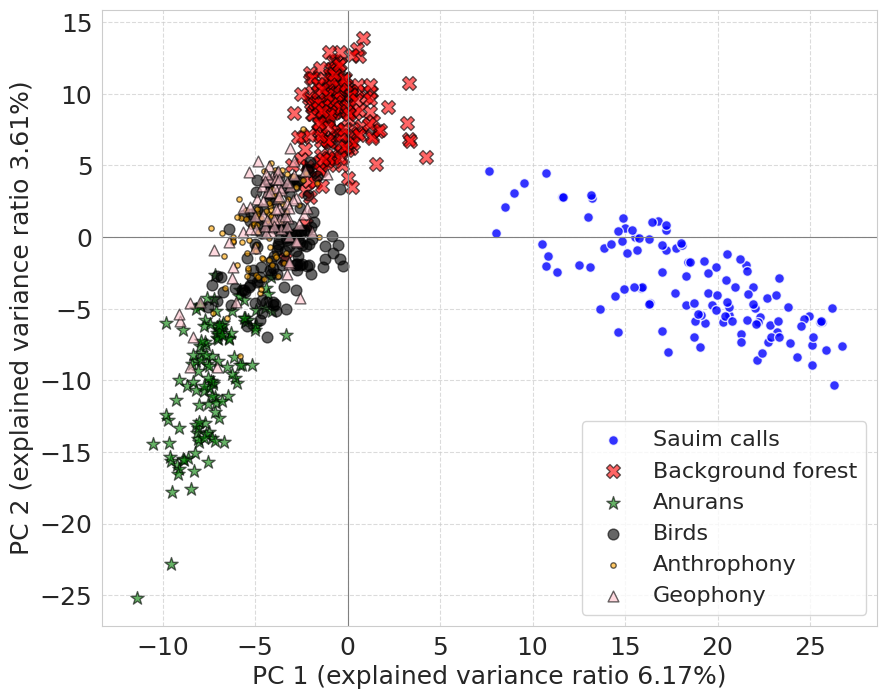

Variância explicada por cada componente principal:
[0.06166889 0.03608314]
Variância acumulada explicada pelas 2 primeiras componentes: 9.78%


In [33]:
data_points = np.concatenate([X_train,
                              background_embedding_vectors,
                              anurans_embedding_vectors,
                              birds_embedding_vectors,
                              anthrophony_embedding_vectors,
                              geophony_embedding_vectors])
m = X_train.shape[0]
n = background_embedding_vectors.shape[0]
p = anurans_embedding_vectors.shape[0]
q = birds_embedding_vectors.shape[0]
r = anthrophony_embedding_vectors.shape[0]
s = geophony_embedding_vectors.shape[0]

scaler = StandardScaler()
data_points_scaled = scaler.fit_transform(data_points)

pca = PCA(n_components=2) # Reduzir para 2 componentes para plotagem 2D
X_train_pca = pca.fit_transform(data_points_scaled) # Ajustar e transformar

plt.figure(figsize=(10, 8), dpi=100)
sns.set_style("whitegrid") # Um estilo de plotagem agradável

# Plotar os dados de treino normais
plt.scatter(X_train_pca[0:m, 0], X_train_pca[0:m, 1],
            label='Sauim calls', alpha=0.8, s=50, color='blue', edgecolor='w')

# Plotar os dados de anomalia
plt.scatter(X_train_pca[m:n+m, 0], X_train_pca[m:n+m, 1],
            label='Background forest', alpha=0.6, s=100, color='red', marker='X', edgecolor='black')

plt.scatter(X_train_pca[m+n:n+m+p, 0], X_train_pca[m+n:n+m+p, 1],
            label='Anurans', alpha=0.6, s=100, color='green', marker='*', edgecolor='black')

plt.scatter(X_train_pca[m+n+p:n+m+p+q, 0], X_train_pca[m+n+p:n+m+p+q, 1],
            label='Birds', alpha=0.6, s=60, color='black', marker='o', edgecolor='black')

plt.scatter(X_train_pca[m+n+p+q:n+m+p+q+r, 0], X_train_pca[m+n+p+q:n+m+p+q+r, 1],
            label='Anthrophony', alpha=0.6, s=60, color='orange', marker='.', edgecolor='black')

plt.scatter(X_train_pca[m+n+p+q+r:n+m+p+q+r+s, 0], X_train_pca[m+n+p+q+r:n+m+p+q+r+s, 1],
            label='Geophony', alpha=0.6, s=60, color='pink', marker='^', edgecolor='black')

plt.xlabel(f'PC 1 (explained variance ratio {pca.explained_variance_ratio_[0]*100:.2f}%)',fontsize=18)
plt.ylabel(f'PC 2 (explained variance ratio {pca.explained_variance_ratio_[1]*100:.2f}%)',fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)  # rotation=0 keeps them horizontal
plt.savefig("PCA.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# --- Informações adicionais do PCA ---
print("Variância explicada por cada componente principal:")
print(pca.explained_variance_ratio_)
print(f"Variância acumulada explicada pelas 2 primeiras componentes: {pca.explained_variance_ratio_.sum()*100:.2f}%")

*   inside normal region (f(x) > 0)
*   on boundary (f(x) == 0)
*   outside/anomaly (f(x) < 0)

9
40
42
46
55
89
99
Outliers: 7


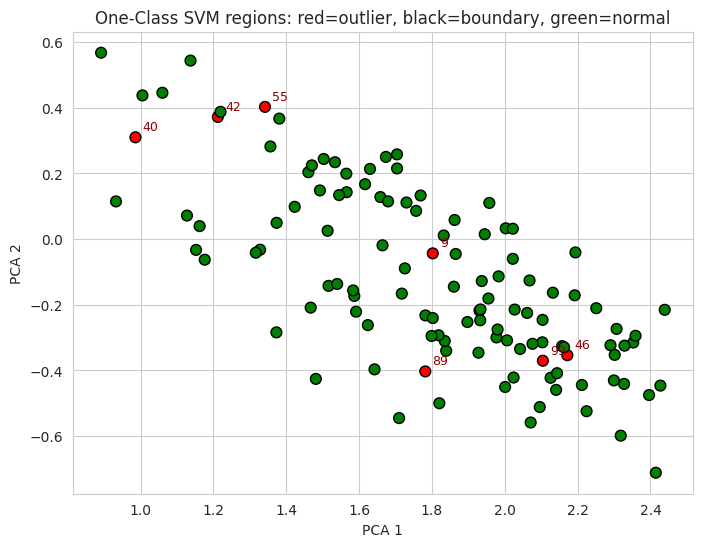

In [34]:

Z = clf.decision_function(X_train)
X_pca = pca.transform(X_train)

# Labels: 1 = inside, 0 = boundary, -1 = outside
labels = np.where(Z > 0, 1, np.where(Z < 0, -1, 0))

# Define 3 colors: inside, boundary, outside
# For example: green (inside), black (boundary), red (outside)
cmap = ListedColormap(['red', 'black', 'green'])  # order matches [-1, 0, 1]

# Map labels to index in the colormap
color_index = labels + 1  # so: -1 → 0, 0 → 1, 1 → 2

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color_index, cmap=cmap, s=60, edgecolor='k')

# Add sample numbers for outliers (red points, label == -1)
for i, (x, y, lbl) in enumerate(zip(X_pca[:, 0], X_pca[:, 1], labels)):
    if lbl == -1:  # outlier
        print(i)
        plt.text(x + 0.02, y + 0.02, str(i), fontsize=9, color='darkred')

print(f"Outliers: {np.sum(labels == -1)}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("One-Class SVM regions: red=outlier, black=boundary, green=normal")
plt.show()


Call density on soundscape

In [ ]:
file_id = '1IO5rqHbT050rpI9op4DmSqIbOOmdQiB_'
if not os.path.exists(os.path.join(extraction_path, 'Mindu_Saguinus bicolor_02.02.19-000.wav')):
    gdown.download(id=file_id, output='Mindu_Saguinus bicolor_02.02.19-000.wav', quiet=False)

y, sr = librosa.load('Mindu_Saguinus bicolor_02.02.19-000.wav', sr=sr)
y = y / np.max(np.abs(y))

# https://drive.google.com/file/d/1RLGL_VqE12oTKG3aq5zwzFjLfd_8Btfk/view?usp=sharing

file_id = '1RLGL_VqE12oTKG3aq5zwzFjLfd_8Btfk'
if not os.path.exists(os.path.join(extraction_path, 'Mindu_Saguinus bicolor_02.02.19-000.csv')):
    gdown.download(id=file_id, output='Mindu_Saguinus bicolor_02.02.19-000.csv', quiet=False)

df = pd.read_csv('Mindu_Saguinus bicolor_02.02.19-000.csv')

In [ ]:
# 1. Distância da função de decisão (positiva = normal, negativa = anomalia)
decision_scores = clf.decision_function(soundscape_embedding_vectors)

soundscape_preds = np.where(decision_scores >= 0, 1, 0)

print(f"Total detections: {np.sum(soundscape_preds == 1)}")
print(f"Confidence range: {decision_scores.min():.3f} to {decision_scores.max():.3f}")

preds_expanded = np.zeros(len(y), dtype=int)

for i, pred in enumerate(soundscape_preds):
    if pred == 0:
        continue  # skip negatives
    start = i * hop_len
    end = start + window_len
    if start >= len(y):
        break
    preds_expanded[start:min(end, len(y))] = 1

len(preds_expanded)

In [ ]:
print("Decision function stats:")
print(f"min: {decision_scores.min():.4f}")
print(f"max: {decision_scores.max():.4f}")
print(f"mean: {decision_scores.mean():.4f}")

plt.hist(decision_scores, bins=100)
plt.vlines(0, 0, 20, linestyles='dashed', colors='red')
plt.title("Distribution of One-Class SVM decision scores")
plt.xlabel("decision_function(x)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
# Converte índice para segundos
time = np.arange(len(y)) / sr

plt.figure(figsize=(23, 4))
plt.plot(time, y)
plt.plot(time, preds_expanded, 'r')
for t in df['TIME'].values:
    plt.axvline(x=t, color='black', linestyle='--')

plt.xlim([100, 325])
# plt.xlim([0, np.max(time)])
plt.ylim([-1, 1.05])
plt.grid(False)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel("Amplitude", fontsize=16)
plt.legend(["Sinal", "Detection", "Annotations"], loc='lower left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("detections.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# STFT
S = np.abs(librosa.stft(y, n_fft=1024, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Nova figura para cada espectrograma
plt.figure(figsize=(20, 3))
librosa.display.specshow(S_db, sr=sr, hop_length=512,
                            x_axis='time', y_axis='hz', cmap='magma')
# plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [ ]:
def find_segments(binary):
    """
    Retorna lista de (start, end) em amostras
    onde binary == 1.
    """
    b = np.asarray(binary).astype(int)
    if b.sum() == 0:
        return []

    diff = np.diff(np.concatenate([[0], b, [0]]))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]

    return list(zip(starts, ends))

# encontra segmentos (sem filtro de duração)
segments = find_segments(preds_expanded)

print(f"Found {len(segments)} segments")

# Loop para gerar um espectrograma por vez
for i, (s, e) in enumerate(segments):
    y_seg = y[s:e]

    # índice da predição correspondente (janela que começa em s)
    pred_index = s // hop_len
    conf = decision_scores[pred_index] if pred_index < len(decision_scores) else None

    # STFT
    S = np.abs(librosa.stft(y_seg, n_fft=2048, hop_length=256))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    # Nova figura para cada espectrograma
    plt.figure(figsize=(10, 3), dpi=200)
    librosa.display.specshow(S_db, sr=sr, hop_length=256,
                             x_axis='time', y_axis='hz', cmap='magma')
    # plt.colorbar(format='%+2.0f dB')

    # # título com confiança
    # if conf is not None:
    #     title = f"Segment {i+1}: {s/sr:.1f}-{e/sr:.1f}s | decision score: {conf:.4f}"
    # else:
    #     title = f"Segment {i+1}: {s/sr:.1f}-{e/sr:.1f}s"

    # plt.title(title)
    plt.tight_layout()
    plt.show()